In [1]:
import os
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Literal, Optional, Tuple, Union

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import logging
from IPython.display import display
from matplotlib.axes import Axes as Axes

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
from src.utils.Csv import Csv
from src.utils.iso18571 import rating_iso_18571
from src.utils.set_rcparams import set_rcparams
from src.utils.UnifySignal import UnifySignal

os.chdir(project_dir)
LOG = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log initialized")

set_rcparams()

2024-12-18 00:59:03,605     INFO  MainProcess  MainThread Log initialized
2024-12-18 00:59:03,606     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2024-12-18 00:59:03,653     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle


In [2]:
B_PATH: Path = Path("/mnt") /"q" / "Val_Chain_Sims" / "AB_Testing"
B_PATH.is_dir()

True

In [3]:
# read report data
CSV = Csv(csv_path=B_PATH / "From_Reports" / "report_data.csv.csv.zip", compress=True)
DB_REPORT: pd.DataFrame = CSV.read()
REPORT_ASS = ["HW TH Report", "CAE TH Report"]
DB_REPORT.replace({"CAE NHTSA": REPORT_ASS[1], "Test NHTSA": REPORT_ASS[0]}, inplace=True)
#DB_REPORT.fillna(0, inplace=True)
display(DB_REPORT)

2024-12-18 00:59:03,697     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/From_Reports/report_data.csv.zip


,Value,Time,Channel,Source,Case
0,-0.2951,1.0,00COG00000VH00ACXD,CAE TH Report,Full Frontal
1,0.0105,2.0,00COG00000VH00ACXD,CAE TH Report,Full Frontal
2,0.0940,3.0,00COG00000VH00ACXD,CAE TH Report,Full Frontal
3,-0.1007,4.0,00COG00000VH00ACXD,CAE TH Report,Full Frontal
4,-1.3470,5.0,00COG00000VH00ACXD,CAE TH Report,Full Frontal
...,...,...,...,...,...
16953,0.5883,135.0,00COG00000VH00ACRD,HW TH Report,Oblique Right
16954,0.4951,136.0,00COG00000VH00ACRD,HW TH Report,Oblique Right
16955,0.3824,137.0,00COG00000VH00ACRD,HW TH Report,Oblique Right
16956,0.2644,138.0,00COG00000VH00ACRD,HW TH Report,Oblique Right


In [4]:
# read Other Data
DB_CAES: List[pd.DataFrame] = []
CASES: List[str] = [
    "000_Base_Model",
    "100_Guided_BIW",
    "200_PAB_Simplified",
    "300_Seat_Simplified",
    "400_HIII",
    "500_NoCAB",
    "600_NoDoor",
    "700_Simplified_Belt",
    "800_Simplified_BIW",
    "900_NoIntrusion",
    "950_Dash_Rigid",
    "990_Carpet_Rigid",
]
for case in CASES:
    LOG.info("Read %s", case)

    CSV = Csv(csv_path=B_PATH / case / f"extracted.csv.zip", compress=True)
    DB_CAES.append(CSV.read())


    DB_CAES[-1].replace(
        {"Assemblies_1": "SP 48", "Assemblies_2": "DP 48", "Assemblies_3": "SP 96", "Assemblies_4": "DP 96"}, inplace=True
    )

    DB_CAES[-1].fillna(0, inplace=True)

2024-12-18 00:59:03,829     INFO  MainProcess  MainThread Read 000_Base_Model
2024-12-18 00:59:03,832     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/000_Base_Model/extracted.csv.zip
2024-12-18 00:59:36,667     INFO  MainProcess  MainThread Read 100_Guided_BIW
2024-12-18 00:59:36,668     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/100_Guided_BIW/extracted.csv.zip
2024-12-18 00:59:57,354     INFO  MainProcess  MainThread Read 200_PAB_Simplified
2024-12-18 00:59:57,355     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/200_PAB_Simplified/extracted.csv.zip
2024-12-18 01:00:17,987     INFO  MainProcess  MainThread Read 300_Seat_Simplified
2024-12-18 01:00:17,989     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/300_Seat_Simplified/extracted.csv.zip
2024-12-18 01:00:42,021     INFO  MainProcess  MainThread Read 400_HIII
2024-12-18 01:00:42,025     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Si

In [5]:
DB_CAES[0]

,Time,Value,Channel,Source,Assembly,Configuration,Case,Side
0,0.0,15.5587,00COG00000VH00VEXD,CAE THI,SP 48,000_Base_Model,Full Frontal,0.0
1,0.1,15.5586,00COG00000VH00VEXD,CAE THI,SP 48,000_Base_Model,Full Frontal,0.0
2,0.2,15.5584,00COG00000VH00VEXD,CAE THI,SP 48,000_Base_Model,Full Frontal,0.0
3,0.3,15.5583,00COG00000VH00VEXD,CAE THI,SP 48,000_Base_Model,Full Frontal,0.0
4,0.4,15.5582,00COG00000VH00VEXD,CAE THI,SP 48,000_Base_Model,Full Frontal,0.0
...,...,...,...,...,...,...,...,...
8069755,139.6,-22.4571,03PELVLOC0TH50DSZD,CAE THI,DP 96,000_Base_Model,Oblique Right,0.0
8069756,139.7,-22.4549,03PELVLOC0TH50DSZD,CAE THI,DP 96,000_Base_Model,Oblique Right,0.0
8069757,139.8,-22.4529,03PELVLOC0TH50DSZD,CAE THI,DP 96,000_Base_Model,Oblique Right,0.0
8069758,139.9,-22.4511,03PELVLOC0TH50DSZD,CAE THI,DP 96,000_Base_Model,Oblique Right,0.0


In [6]:
[x for x in DB_CAES[0]["Channel"].unique() if "03HEAD0000TH50ACR" in x]

['03HEAD0000TH50ACRD', '03HEAD0000TH50ACRB', '03HEAD0000TH50ACRC']

In [7]:
[x for x in DB_REPORT["Channel"].unique() if "03HEAD0000TH50ACR" in x]

['03HEAD0000TH50ACRD']

2024-12-18 01:03:34,580     INFO  MainProcess  MainThread maxp pruned
2024-12-18 01:03:34,589     INFO  MainProcess  MainThread cmap pruned
2024-12-18 01:03:34,592     INFO  MainProcess  MainThread post pruned
2024-12-18 01:03:34,594     INFO  MainProcess  MainThread FFTM dropped
2024-12-18 01:03:34,602     INFO  MainProcess  MainThread GPOS pruned
2024-12-18 01:03:34,604     INFO  MainProcess  MainThread GSUB pruned
2024-12-18 01:03:34,608     INFO  MainProcess  MainThread glyf pruned
2024-12-18 01:03:34,609     INFO  MainProcess  MainThread Added gid0 to subset
2024-12-18 01:03:34,611     INFO  MainProcess  MainThread Added first four glyphs to subset
2024-12-18 01:03:34,612     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 14 glyphs before
2024-12-18 01:03:34,614     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'R', 'T', 'five', 'glyph1', 'one', 'space', 'uni000D', 'zero']
2024-12-18 01:03:34,616     INFO  MainProcess  MainThread Gl

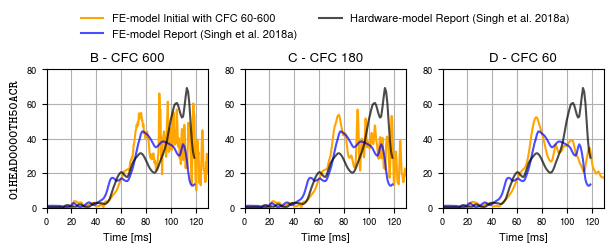

In [8]:
def plot():
    ch_name = "01HEAD0000TH50ACR"
    case = "Oblique Right"
    cs = {"HW TH Report": "black", "CAE TH Report": "blue", "CAE New": "orange"}
    names = {
        "HW TH Report": "Hardware-model Report (Singh et al. 2018a)",
        "CAE TH Report": "FE-model Report (Singh et al. 2018a)",
    }
    cfc_classes = {"D": 60, "B": 600, "C": 180}
    fig_width: float = 1 * (448.13095 / 72) -0.2
    fig_height: float = 0.4 * fig_width
    filters = ["B", "C", "D"]
    fig, ax = plt.subplot_mosaic(
        mosaic=[["L", "L", "L"], ["B", "C", "D"]],
        layout="constrained",
        height_ratios=[0.1, 1],
    )

    for cfc in filters:
        db = DB_CAES[0][
            DB_CAES[0]["Channel"].eq(f"{ch_name}{cfc}") & DB_CAES[0]["Case"].eq(case) & DB_CAES[0]["Assembly"].eq("SP 48")
        ]
        ax[cfc].plot(db["Time"], db["Value"], label="FE-model Initial with CFC 60-600", c=cs["CAE New"], alpha=1)

        for source in DB_REPORT["Source"].unique():
            db = DB_REPORT[DB_REPORT["Channel"].eq(f"{ch_name}D") & DB_REPORT["Source"].eq(source) & DB_REPORT["Case"].eq(case)]
            ax[cfc].plot(db["Time"], db["Value"], label=names[source], c=cs[source], alpha=0.7)

        ax[cfc].set_title(f"{cfc} - CFC {cfc_classes[cfc]}")
        ax[cfc].set_xlabel("Time [ms]")
        ax[cfc].grid()
        ax[cfc].set_xlim(0, 130)
        ax[cfc].set_xticks(np.arange(0, 121, 20))
        ax[cfc].set_ylim(0, 80)

    ax["L"].legend(*ax[filters[0]].get_legend_handles_labels(), loc="center", ncol=2)
    ax["L"].axis("off")
    ax[filters[0]].set_ylabel(ch_name, {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
    fig.set_figheight(fig_height)
    fig.set_figwidth(fig_width)
    fig.savefig(Path("reports") / "CFC_comp.pdf")


plot()